# medARC

Figures 2 and 6, Statistics, and Supplementary Figures 

In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scienceplots
import seaborn as sns
import string
import sys
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import bootstrap


plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 300

def brier_score(df, prob_c, true_c):
    """
    Calculate Brier score
    Parameters: df (pd.Dataframe) containing probabilities and true labels
    Returns: (float), Brier score
    """
    sq_diff = np.square(df[prob_c] - df[true_c])
    return sq_diff.mean()


def calculate_entropy_based_consistency(answers):
    """
    Calculate entropy-based consistency, following Lyu et al. (2024)
    Parameters: answers (list) generated by the model for the same question.
    Returns: (float), entropy-based consistency score (range [0, 1]).
    """
    answers = [a if pd.notna(a) else "nan" for a in answers]
    value,counts = np.unique(answers, return_counts=True)
    norm_counts = counts / counts.sum()
    base = len(value) # cardinality of unique answer set
    if base == 1:
        norm_ent = 0
    else:
        norm_ent = -(norm_counts * np.log(norm_counts)/np.log(base)).sum()
    return 1 - norm_ent    

    
def calculate_sc_ent(df):
    """
    Calculate entropy-based consistency, following Lyu et al. (2024)
    Parameters: df (pd.DataFrame), where each column represents a question
                       and each row represents a run of the model.
    Returns: pd.Series, consistency scores for each question.
    """
    consistency_scores = df.apply(calculate_entropy_based_consistency, axis=0)
    return consistency_scores


def fix_model_name(model_name):
    model_name = model_name.replace(r'-Instruct-*', '')
    model_name = model_name.replace(r'v0.1', '')
    model_name = model_name.replace(r'-20240229', '')
    model_name = model_name.replace(r'-2024-12-17', '')
    model_name = model_name.replace(r'claude', 'Claude')
    model_name = model_name.replace(r'gemini', 'Gemini')
    model_name = model_name.replace(r'deepseek', 'DeepSeek')
    model_name = model_name.replace(r'-latest', '')
    model_name = model_name.replace(r'Reasoner', 'R1')
    model_name = model_name.replace(r'Chat', 'V3')
    model_name = model_name.replace(r'reasoner', 'R1')
    model_name = model_name.replace(r'chat', 'V3')
    model_name = model_name.replace(r'gpt', 'GPT')

    return model_name

In [2]:
# Testing 
df = pd.DataFrame({
    "question_ID001": ["D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D"],
    "question_ID002": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", np.nan, "A", "A"],
    "question_ID003": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", np.nan, np.nan, "A", "A", "A"],
    "question_ID004": ["A", "C", "A", "D", "C", "E", "B", "X", "A", "Y", "Z", "Y", "Q", np.nan, "A2", "A4"]
})

sc_ent_scores = calculate_sc_ent(df)
print(sc_ent_scores) 

question_ID001    1.000000
question_ID002    0.662710
question_ID003    0.456436
question_ID004    0.036860
dtype: float64


In [3]:
main_path = 'eval_uq_results'
baseline_path = 'eval_uq_baseline_results'
model_result_paths = glob.glob(os.path.join(main_path, '*/')) + glob.glob(os.path.join(baseline_path, '*/'))

all_model_uq_results = {}
all_model_cal_agr_results = {}
all_model_cal_ent_results = {}
all_model_bs_agree_results = {}
all_model_bs_entropy_results = {}
all_model_raw_results = {} # RAW ACCURACY WITHOUT UQ

for model_path in tqdm(model_result_paths):

    uq_file_pattern = os.path.join(model_path, 'run*/*_health_result.json')
    uq_file_paths = glob.glob(uq_file_pattern)

    final_df = pd.DataFrame()
    
    for n, file_path in enumerate(uq_file_paths):
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)

            pred_dict = {}
            for item in content:
                question_id = item["question_id"]
                if 'baseline-' in file_path:
                    question_id = f'ID{question_id}' # Harmonize to medARC dataset questionID format
                pred_dict[question_id] = item["pred"] 
            
            pred_df = pd.DataFrame([pred_dict])

            pred_df.columns = [f"question_{col}" for col in pred_df.columns]
            final_df = pd.concat([final_df, pred_df], ignore_index=True)

            if n == 0:
                correct_answers = {}
                for item in content:
                    answer = item["answer"] 
                    if answer == None:
                        mult_choice_answers = list(string.ascii_uppercase[:27])
                        answer_idx = item['answer_index']
                        answer = mult_choice_answers[answer_idx]
                    question_id = item["question_id"]
                    if 'baseline-' in file_path:
                        question_id = f'ID{question_id}' # Harmonize to medARC dataset questionID format
                    correct_answers[question_id] = answer
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    sample_consistency = {}

    for n, col in enumerate(final_df.columns):
        counts = Counter(final_df[col])

        most_common_response, most_common_count = counts.most_common(1)[0]


        total_responses = len(final_df[col])
        consistency_fraction = most_common_count / total_responses

        question_id = col.split('_')[1]            

            
        # Check if most common response matches the correct answer
        is_correct = 1 if most_common_response == correct_answers.get(question_id) else 0
        # if 'baseline-' in model_path:
        #     print(question_id, correct_answers.get(question_id), most_common_response, is_correct)
        #     sys.exit()
        sample_consistency[question_id] = {
            "sample_consistency_agree": consistency_fraction,
            "correct": is_correct
        }

    sample_consistency_df = pd.DataFrame.from_dict(sample_consistency, orient='index')
    sample_consistency_df.index.name = 'question_id'

    sc_ent_scores = calculate_sc_ent(final_df)

    model_name = model_path.split('/')[1]
    model_name = fix_model_name(model_name)

    all_model_uq_results[model_name] = {'Sample Consistency (Agr)': sample_consistency_df['sample_consistency_agree'].mean(),
                                        'Sample Consistency (Ent)': sc_ent_scores.mean(),
                                        'Accuracy': sample_consistency_df['correct'].mean(), 
                                       }

    # Add entropy confidence scores
    sample_consistency_df['sample_consistency_ent'] = sc_ent_scores.values

    # Reliability Plots, first bin 'confidence' into deciles
    sample_consistency_df['confidence_bin_agr'] = pd.qcut(sample_consistency_df.rank(method='first')['sample_consistency_agree'], 
                                                        7, duplicates='raise')
    
    # Calculate mean confidence, accuracy for each bin 
    all_model_cal_agr_results[model_name] = sample_consistency_df.groupby('confidence_bin_agr', observed=False).agg(
        average_confidence_agr=('sample_consistency_agree', lambda x: x.mean() ),
        observed_accuracy=('correct', lambda x: x.mean() * 100)
    )

    # Bin 'confidence' into deciles
    sample_consistency_df['confidence_bin_ent'] = pd.qcut(sample_consistency_df.rank(method='first')['sample_consistency_ent'], 
                                                        5, duplicates='raise')
    
    # Calculate mean confidence, accuracy for each bin 
    all_model_cal_ent_results[model_name] = sample_consistency_df.groupby('confidence_bin_ent', observed=False).agg(
        average_confidence_ent=('sample_consistency_ent', lambda x: x.mean() ),
        observed_accuracy=('correct', lambda x: x.mean() * 100)
    )

    # Calculate Brier Scores
    all_model_bs_agree_results[model_name] = brier_score(sample_consistency_df, 'sample_consistency_agree', 'correct')
    all_model_bs_entropy_results[model_name] = brier_score(sample_consistency_df, 'sample_consistency_ent', 'correct')
    
    # RAW ACCURACY PER RUN WITHOUT UNCERTAIN QUANTIFICATION
    file_pattern = os.path.join(model_path, 'run*/*_health_summary.json')
    file_paths = glob.glob(file_pattern)
        
    data = []
    for file_path in file_paths:
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)
            
            accuracy = content['health']['acc']
            
            model_name = os.path.basename(file_path).replace('_health_summary.json', '')  # Remove the suffix to get the model name
            model_name = fix_model_name(model_path)

            data.append({'model': model_name, 'accuracy': accuracy})
        
        except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_path}: {e}")

    df = pd.DataFrame(data)
    df['model'] = df['model'].str.replace(r'-Instruct-*', '', regex=True)
    df['model'] = df['model'].str.replace(r'v0.1', '', regex=True)
    df['model'] = df['model'].str.replace(r'-20240229', '', regex=True)
    df['model'] = df['model'].str.replace(r'-20241217', '', regex=True)
    df['model'] = df['model'].str.replace(r'-chat', 'V3', regex=True)
    df['model'] = df['model'].str.replace(r'-reasoner', 'R1', regex=True)

    data = df.loc[:, 'accuracy'].values
    res = bootstrap(
        data=(data,),                 # (data,) -> single dataset
        statistic=np.mean,            # function to bootstrap
        confidence_level=0.95,        # 95% CI
        n_resamples=2000,             # number of bootstrap resamples
        method='BCa',                 # Bias-corrected and accelerated (BCa)
        random_state=42               # for reproducibility
    )
    
    ci = res.confidence_interval

    all_model_raw_results[model_name.split('/')[1]] = [df.loc[:, 'accuracy'].mean(), ci]

  0%|          | 0/17 [00:00<?, ?it/s]

In [4]:
all_model_cal_agr_results

{'DeepSeek-V3':                     average_confidence_agr  observed_accuracy
 confidence_bin_agr                                           
 (0.999, 15.143]                   0.546667          53.333333
 (15.143, 29.286]                  0.695238          57.142857
 (29.286, 43.429]                  0.790476          64.285714
 (43.429, 57.571]                  0.919048          71.428571
 (57.571, 71.714]                  0.942857          42.857143
 (71.714, 85.857]                  1.000000          28.571429
 (85.857, 100.0]                   1.000000          53.333333,
 'Claude-3-opus':                     average_confidence_agr  observed_accuracy
 confidence_bin_agr                                           
 (0.999, 15.143]                   0.542222          40.000000
 (15.143, 29.286]                  0.714286          57.142857
 (29.286, 43.429]                  0.914286          50.000000
 (43.429, 57.571]                  1.000000          57.142857
 (57.571, 71.714]     

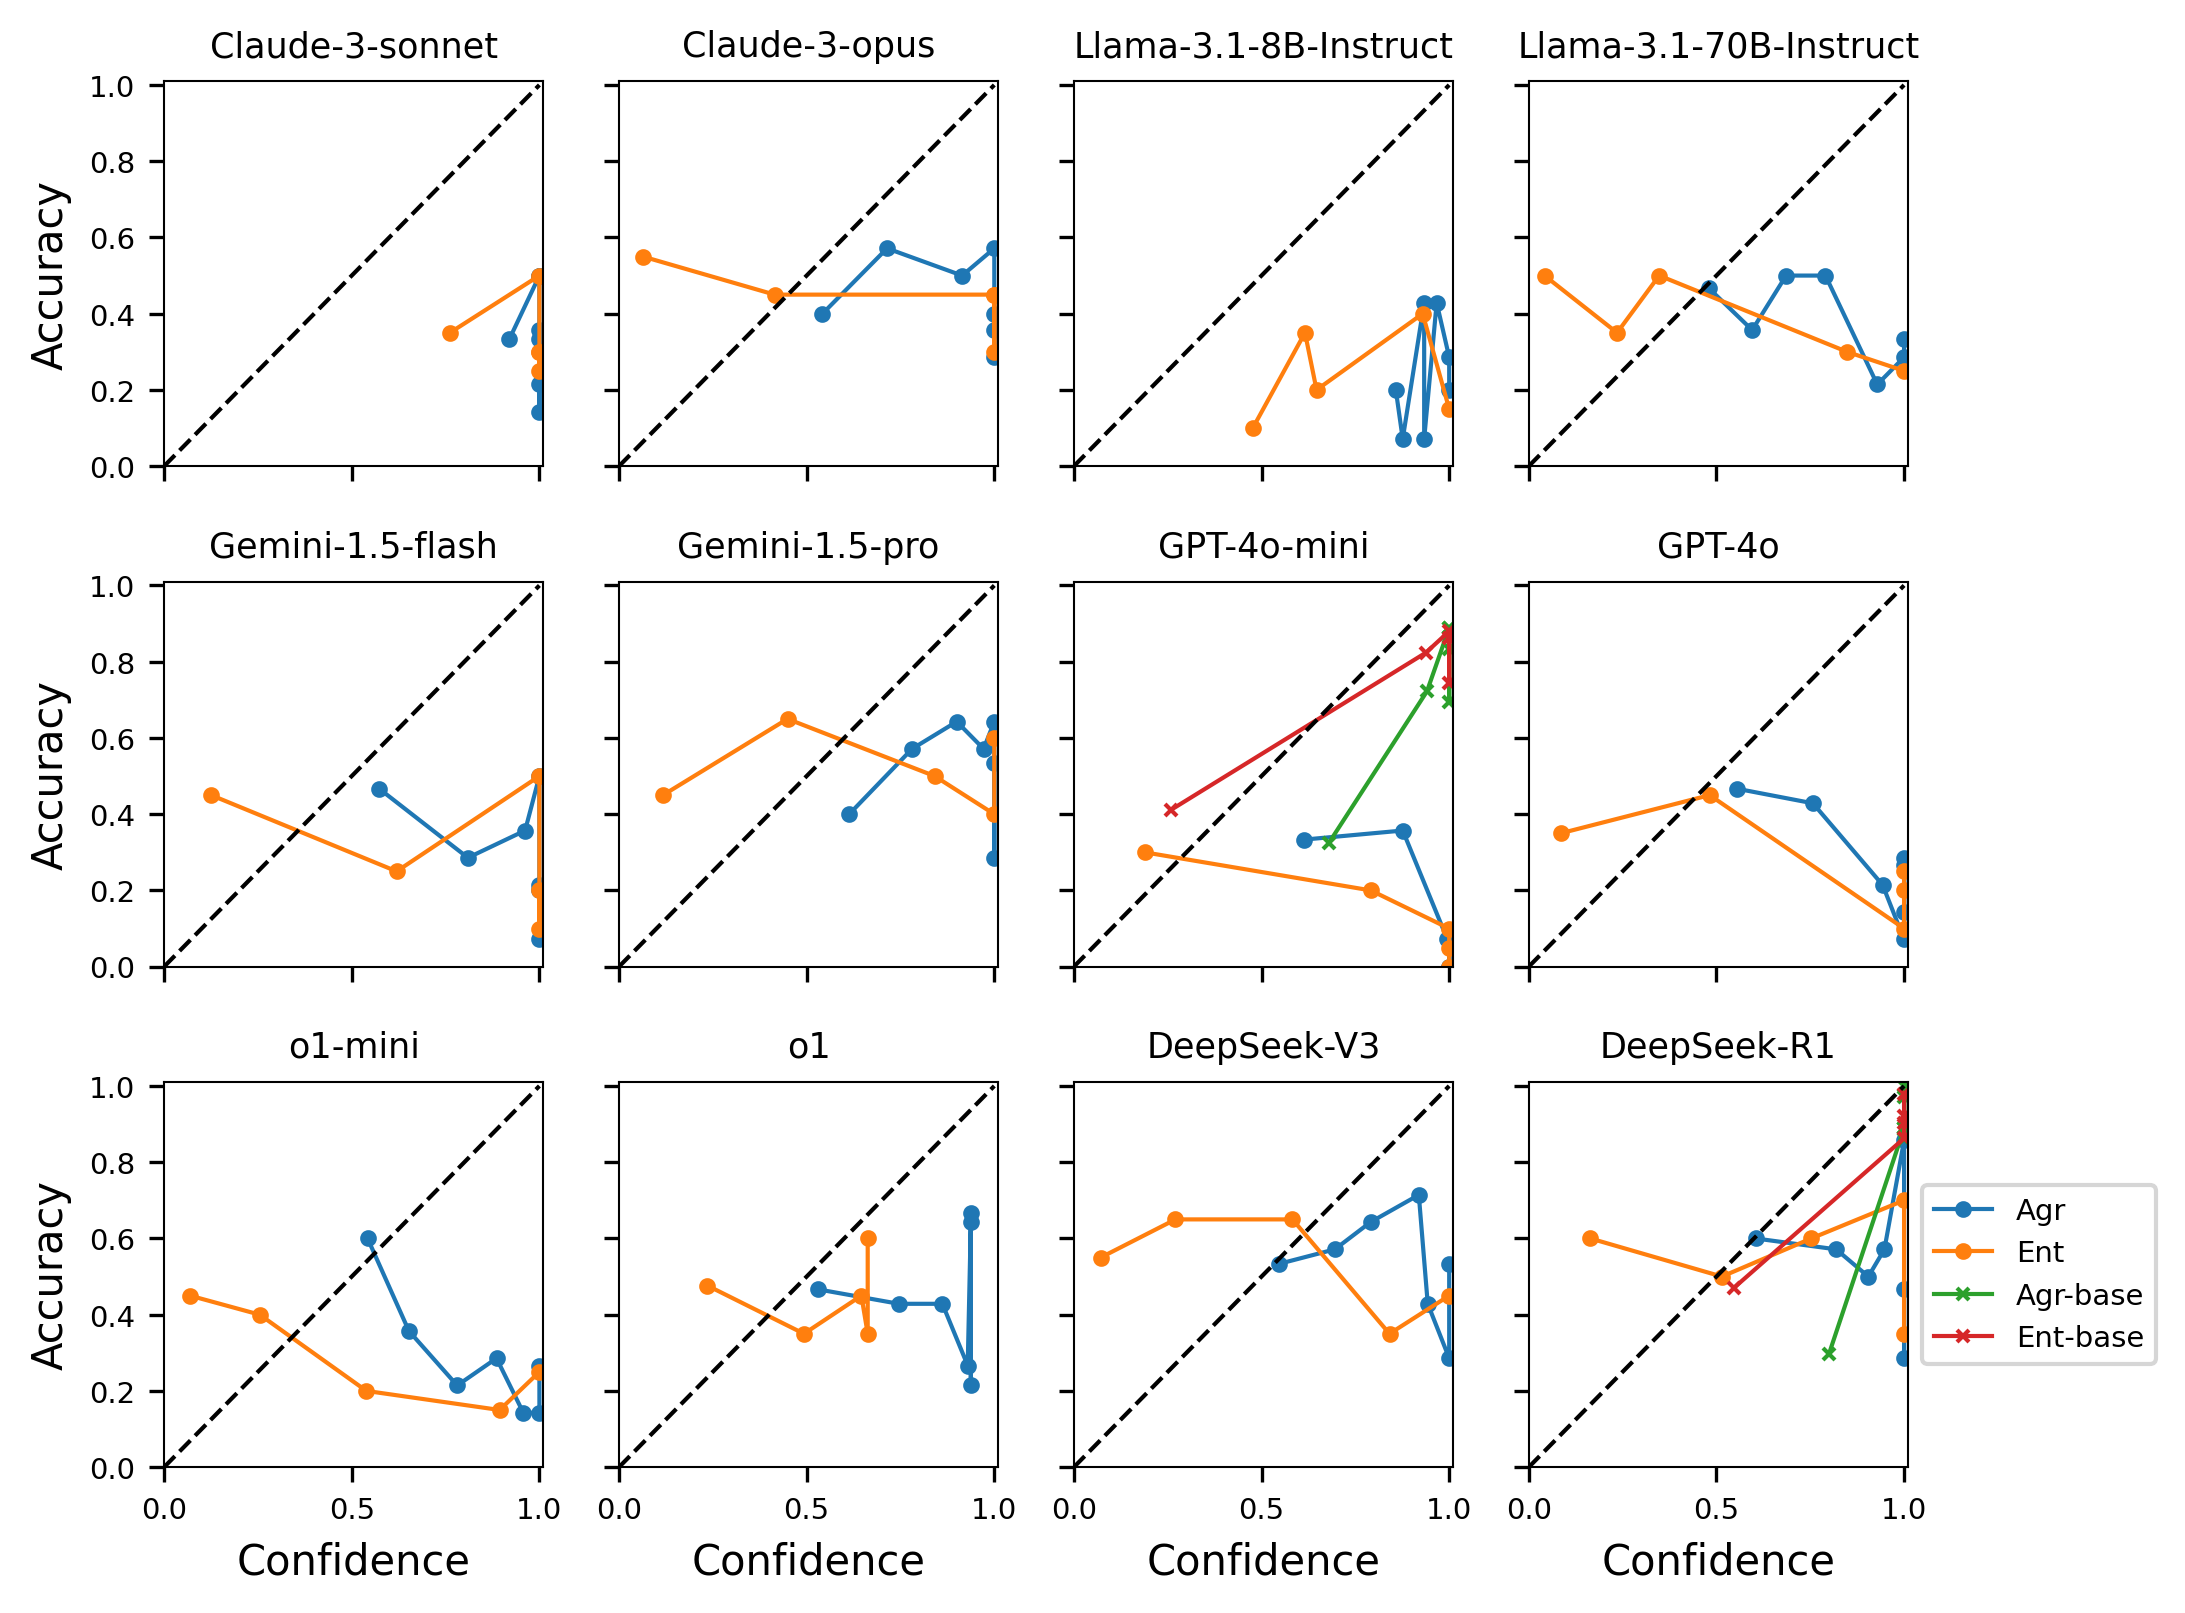

In [5]:

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(7.5,6), sharex=True, sharey=True)
axes = axes.flatten()
i = 0

for n, model in enumerate(['Claude-3-sonnet', 'Claude-3-opus', 
              'Llama-3.1-8B-Instruct', 'Llama-3.1-70B-Instruct', 
            'Gemini-1.5-flash', 'Gemini-1.5-pro', 
              'GPT-4o-mini', 'GPT-4o', 'o1-mini', 'o1', 'DeepSeek-V3', 'DeepSeek-R1']):
    cal_agr_res = all_model_cal_agr_results[model]
    cal_ent_res = all_model_cal_ent_results[model]

    ax = axes[i]
    ax.plot(cal_agr_res['average_confidence_agr'], 
            cal_agr_res['observed_accuracy']/100, marker='o', linestyle='-',  
            label='Agr',linewidth=1)
    ax.plot(cal_ent_res['average_confidence_ent'], 
            cal_ent_res['observed_accuracy']/100, marker='o', linestyle='-',  
            label='Ent',linewidth=1)

    if model == 'GPT-4o-mini' or model == 'DeepSeek-R1':
        baseline_model = 'baseline-' + model
        cal_agr_res_baseline = all_model_cal_agr_results[baseline_model]
        cal_ent_res_baseline = all_model_cal_ent_results[baseline_model]
    
        ax = axes[i]
        ax.plot(cal_agr_res_baseline['average_confidence_agr'], 
                cal_agr_res_baseline['observed_accuracy']/100, marker='x', linestyle='-',  
                label='Agr-base',linewidth=1)
        ax.plot(cal_ent_res_baseline['average_confidence_ent'], 
                cal_ent_res_baseline['observed_accuracy']/100, marker='x', linestyle='-',  
                label='Ent-base',linewidth=1)

    ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

    ax.set_ylim(0, 1.01)
    ax.set_xlim(0, 1.01)
    ax.set_title(model)

    if n>=8:
        ax.set_xlabel('Confidence',fontsize=10)
    if n in [0, 4, 8]:    
        ax.set_ylabel('Accuracy',fontsize=10)
    
    # if n == 11: 
    #     ax.legend(fontsize=6,loc='upper left')

    i+=1


# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(False)
plt.subplots_adjust(hspace=0.3)
plt.show()


In [6]:
# Prep for plotting agreement-based SC
df_bs = pd.DataFrame(all_model_bs_agree_results.items(), columns=['Model (det)', 'Brier Score'])

family = []
for m in df_bs['Model (det)']:
    if 'baseline' in m:
        family.append('Baseline')
    elif 'claude' in m or 'Claude' in m:
        family.append('Claude')
    elif 'Llama' in m or 'llama' in m:
        family.append('Llama')
    elif 'Gemini' in m:
        family.append('Gemini')
    elif 'deepseek' in m or 'DeepSeek' in m:
        family.append('DeepSeek')
    elif 'Mistral' in m:
        family.append('Mistral')
    else:
        family.append('OpenAI')


df_bs['Family'] = family
df_bs['Model'] = ['DeepSeek-V3', 'Claude Opus', 'Llama-3.1-70B', 'Llama-3.1-8B',  
                   'Gemini-1.5-Pro', 'Claude-3-Sonnet', 'GPT-4o', 'Llama-3.1-405B',
                  'Mistral-7B', 'DeepSeek-R1', 'Gemini-1.5-Flash', 'o1-mini', 'GPT-4o-mini',
                   'o1', 'Llama-3.3-70B', 'MMLUP-DeepSeek-R1', 'MMLUP-GPT-4o-mini']

accs, CIs_l, CIs_h = [], [], []
for m in df_bs['Model (det)']:
    accs.append(all_model_raw_results[m][0])
    CIs_l.append(all_model_raw_results[m][1][0])
    CIs_h.append(all_model_raw_results[m][1][1])

df_bs['Accuracy'] = accs
df_bs['CI_l'] = CIs_l
df_bs['CI_h'] = CIs_h

df_bs = df_bs.sort_values(['Family'], ascending=[True])
df_bs

,Model (det),Brier Score,Family,Model,Accuracy,CI_l,CI_h
16,baseline-GPT-4o-mini,0.202957,Baseline,MMLUP-GPT-4o-mini,0.743832,0.739370,0.748556
15,baseline-DeepSeek-R1,0.135766,Baseline,MMLUP-DeepSeek-R1,0.836745,0.832808,0.843832
1,Claude-3-opus,0.485644,Claude,Claude Opus,0.418667,0.405333,0.430667
5,Claude-3-sonnet,0.645333,Claude,Claude-3-Sonnet,0.336667,0.326384,0.339333
9,DeepSeek-R1,0.390711,DeepSeek,DeepSeek-R1,0.524913,0.515076,0.533700
0,DeepSeek-V3,0.387556,DeepSeek,DeepSeek-V3,0.495571,0.480152,0.514667
10,Gemini-1.5-flash,0.622667,Gemini,Gemini-1.5-Flash,0.285333,0.276667,0.293333
4,Gemini-1.5-pro,0.401511,Gemini,Gemini-1.5-Pro,0.499333,0.484667,0.512667
7,llama3.1-405b-instruct-fp8,0.474044,Llama,Llama-3.1-405B,0.374667,0.358000,0.387333
3,Llama-3.1-8B-Instruct,0.668222,Llama,Llama-3.1-8B,0.256000,0.248000,0.277689


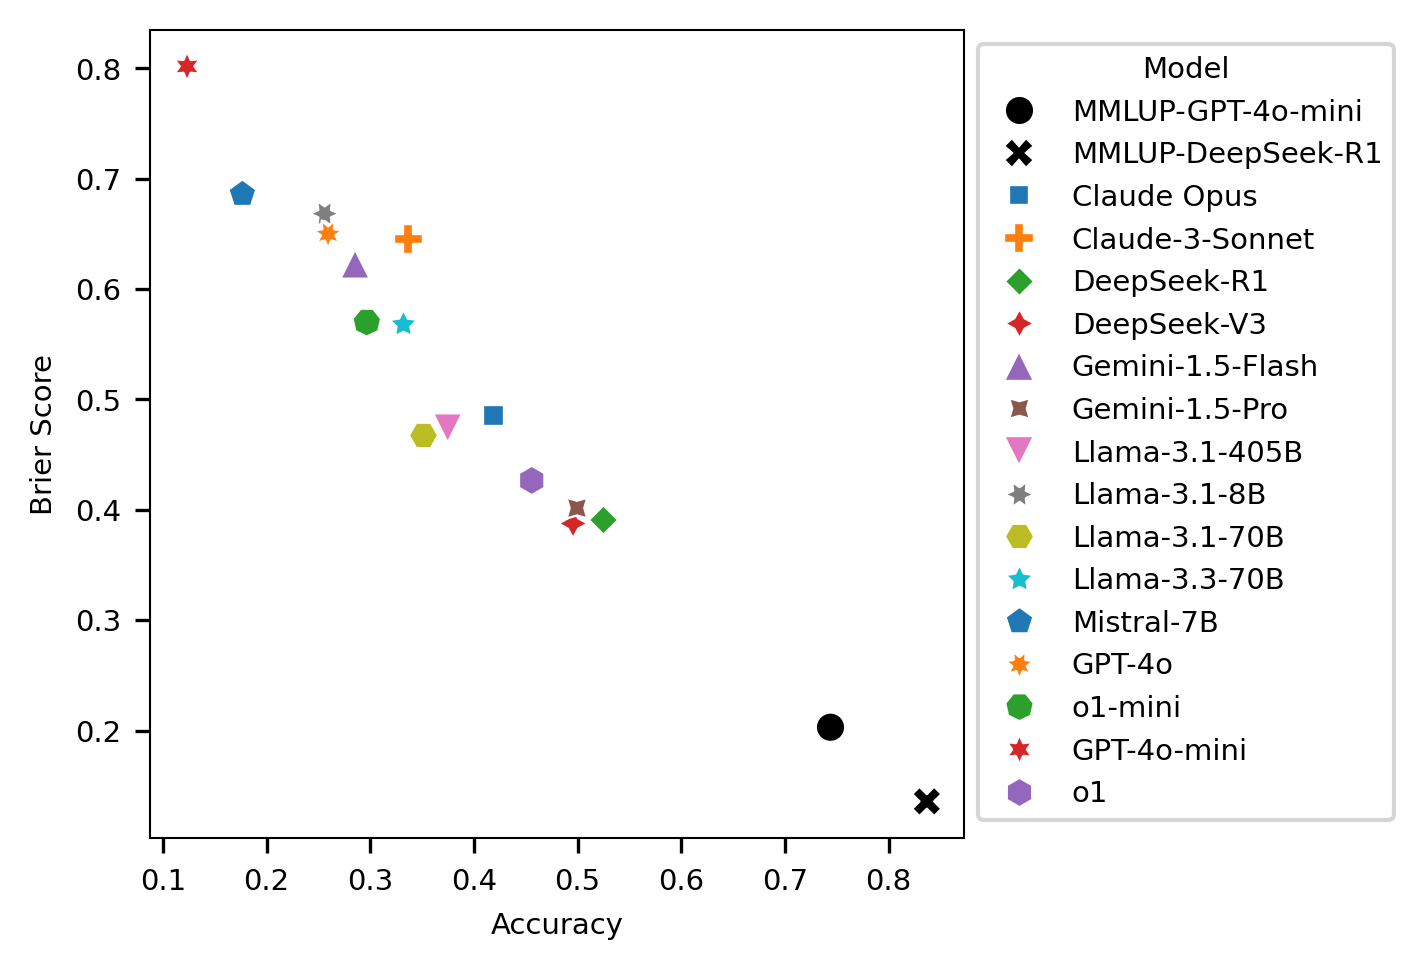

In [10]:

model_names = df_bs['Model'].unique()

baseline_models = [m for m in model_names if "mmlu" in m.lower()]
non_baseline = [m for m in model_names if "mmlu" not in m.lower()]
base_palette = sns.color_palette(n_colors=len(non_baseline))

# Build the color map dict
color_map = {}
idx = 0
for m in model_names:
    if m in baseline_models:
        color_map[m] = 'black'
    else:
        color_map[m] = base_palette[idx]
        idx += 1

plt.figure(figsize=(3.5,3.5))
ax = sns.scatterplot(
    data=df_bs,
    x="Accuracy",
    y="Brier Score",
    s=50,
    hue="Model",
    style="Model",
    palette=color_map
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


In [11]:
# Prepare for plotting entropy-based SC
df_bs_ent = pd.DataFrame(all_model_bs_entropy_results.items(), columns=['Model (det)', 'Brier Score'])

family = []
for m in df_bs_ent['Model (det)']:
    if 'baseline' in m:
        family.append('Baseline')
    elif 'claude' in m or 'Claude' in m:
        family.append('Claude')
    elif 'Llama' in m or 'llama' in m:
        family.append('Llama')
    elif 'Gemini' in m:
        family.append('Gemini')
    elif 'deepseek' in m or 'DeepSeek' in m:
        family.append('DeepSeek')
    elif 'Mistral' in m:
        family.append('Mistral')
    else:
        family.append('OpenAI')


df_bs_ent['Family'] = family
df_bs_ent['Model'] = ['DeepSeek-V3', 'Claude Opus', 'Llama-3.1-70B', 'Llama-3.1-8B',  
                   'Gemini-1.5-Pro', 'Claude-3-Sonnet', 'GPT-4o', 'Llama-3.1-405B',
                  'Mistral-7B', 'DeepSeek-R1', 'Gemini-1.5-Flash', 'o1-mini', 'GPT-4o-mini',
                   'o1', 'Llama-3.3-70B', 'MMLUP-DeepSeek-R1', 'MMLUP-GPT-4o-mini']

accs, CIs_l, CIs_h = [], [], []
for m in df_bs_ent['Model (det)']:
    accs.append(all_model_raw_results[m][0])
    CIs_l.append(all_model_raw_results[m][1][0])
    CIs_h.append(all_model_raw_results[m][1][1])

df_bs_ent['Accuracy'] = accs
df_bs_ent['CI_l'] = CIs_l
df_bs_ent['CI_h'] = CIs_h

df_bs_ent = df_bs_ent.sort_values(['Family'], ascending=[True])
df_bs_ent

,Model (det),Brier Score,Family,Model,Accuracy,CI_l,CI_h
16,baseline-GPT-4o-mini,0.189060,Baseline,MMLUP-GPT-4o-mini,0.743832,0.739370,0.748556
15,baseline-DeepSeek-R1,0.101464,Baseline,MMLUP-DeepSeek-R1,0.836745,0.832808,0.843832
1,Claude-3-opus,0.512626,Claude,Claude Opus,0.418667,0.405333,0.430667
5,Claude-3-sonnet,0.621469,Claude,Claude-3-Sonnet,0.336667,0.326384,0.339333
9,DeepSeek-R1,0.397402,DeepSeek,DeepSeek-R1,0.524913,0.515076,0.533700
0,DeepSeek-V3,0.422892,DeepSeek,DeepSeek-V3,0.495571,0.480152,0.514667
10,Gemini-1.5-flash,0.590773,Gemini,Gemini-1.5-Flash,0.285333,0.276667,0.293333
4,Gemini-1.5-pro,0.373305,Gemini,Gemini-1.5-Pro,0.499333,0.484667,0.512667
7,llama3.1-405b-instruct-fp8,0.395728,Llama,Llama-3.1-405B,0.374667,0.358000,0.387333
3,Llama-3.1-8B-Instruct,0.455783,Llama,Llama-3.1-8B,0.256000,0.248000,0.277689


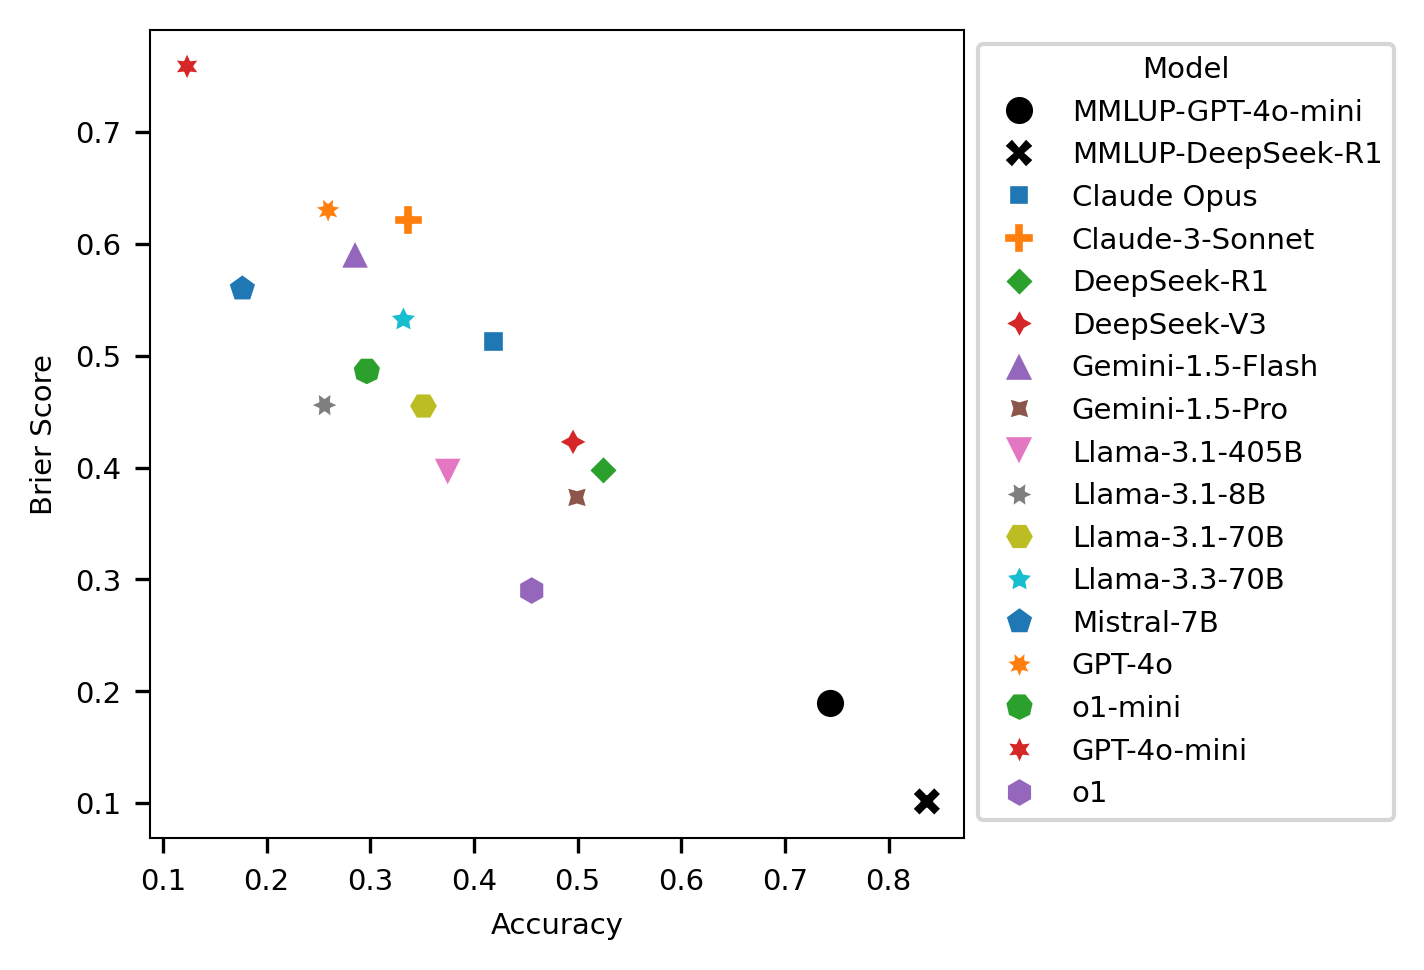

In [12]:

model_names = df_bs_ent['Model'].unique()

baseline_models = [m for m in model_names if "mmlu" in m.lower()]
non_baseline = [m for m in model_names if "mmlu" not in m.lower()]
base_palette = sns.color_palette(n_colors=len(non_baseline))

# Build the color map dict
color_map = {}
idx = 0
for m in model_names:
    if m in baseline_models:
        color_map[m] = 'black'
    else:
        color_map[m] = base_palette[idx]
        idx += 1

plt.figure(figsize=(3.5,3.5))
ax = sns.scatterplot(
    data=df_bs_ent,
    x="Accuracy",
    y="Brier Score",
    s=50,
    hue="Model",
    style="Model",
    palette=color_map
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


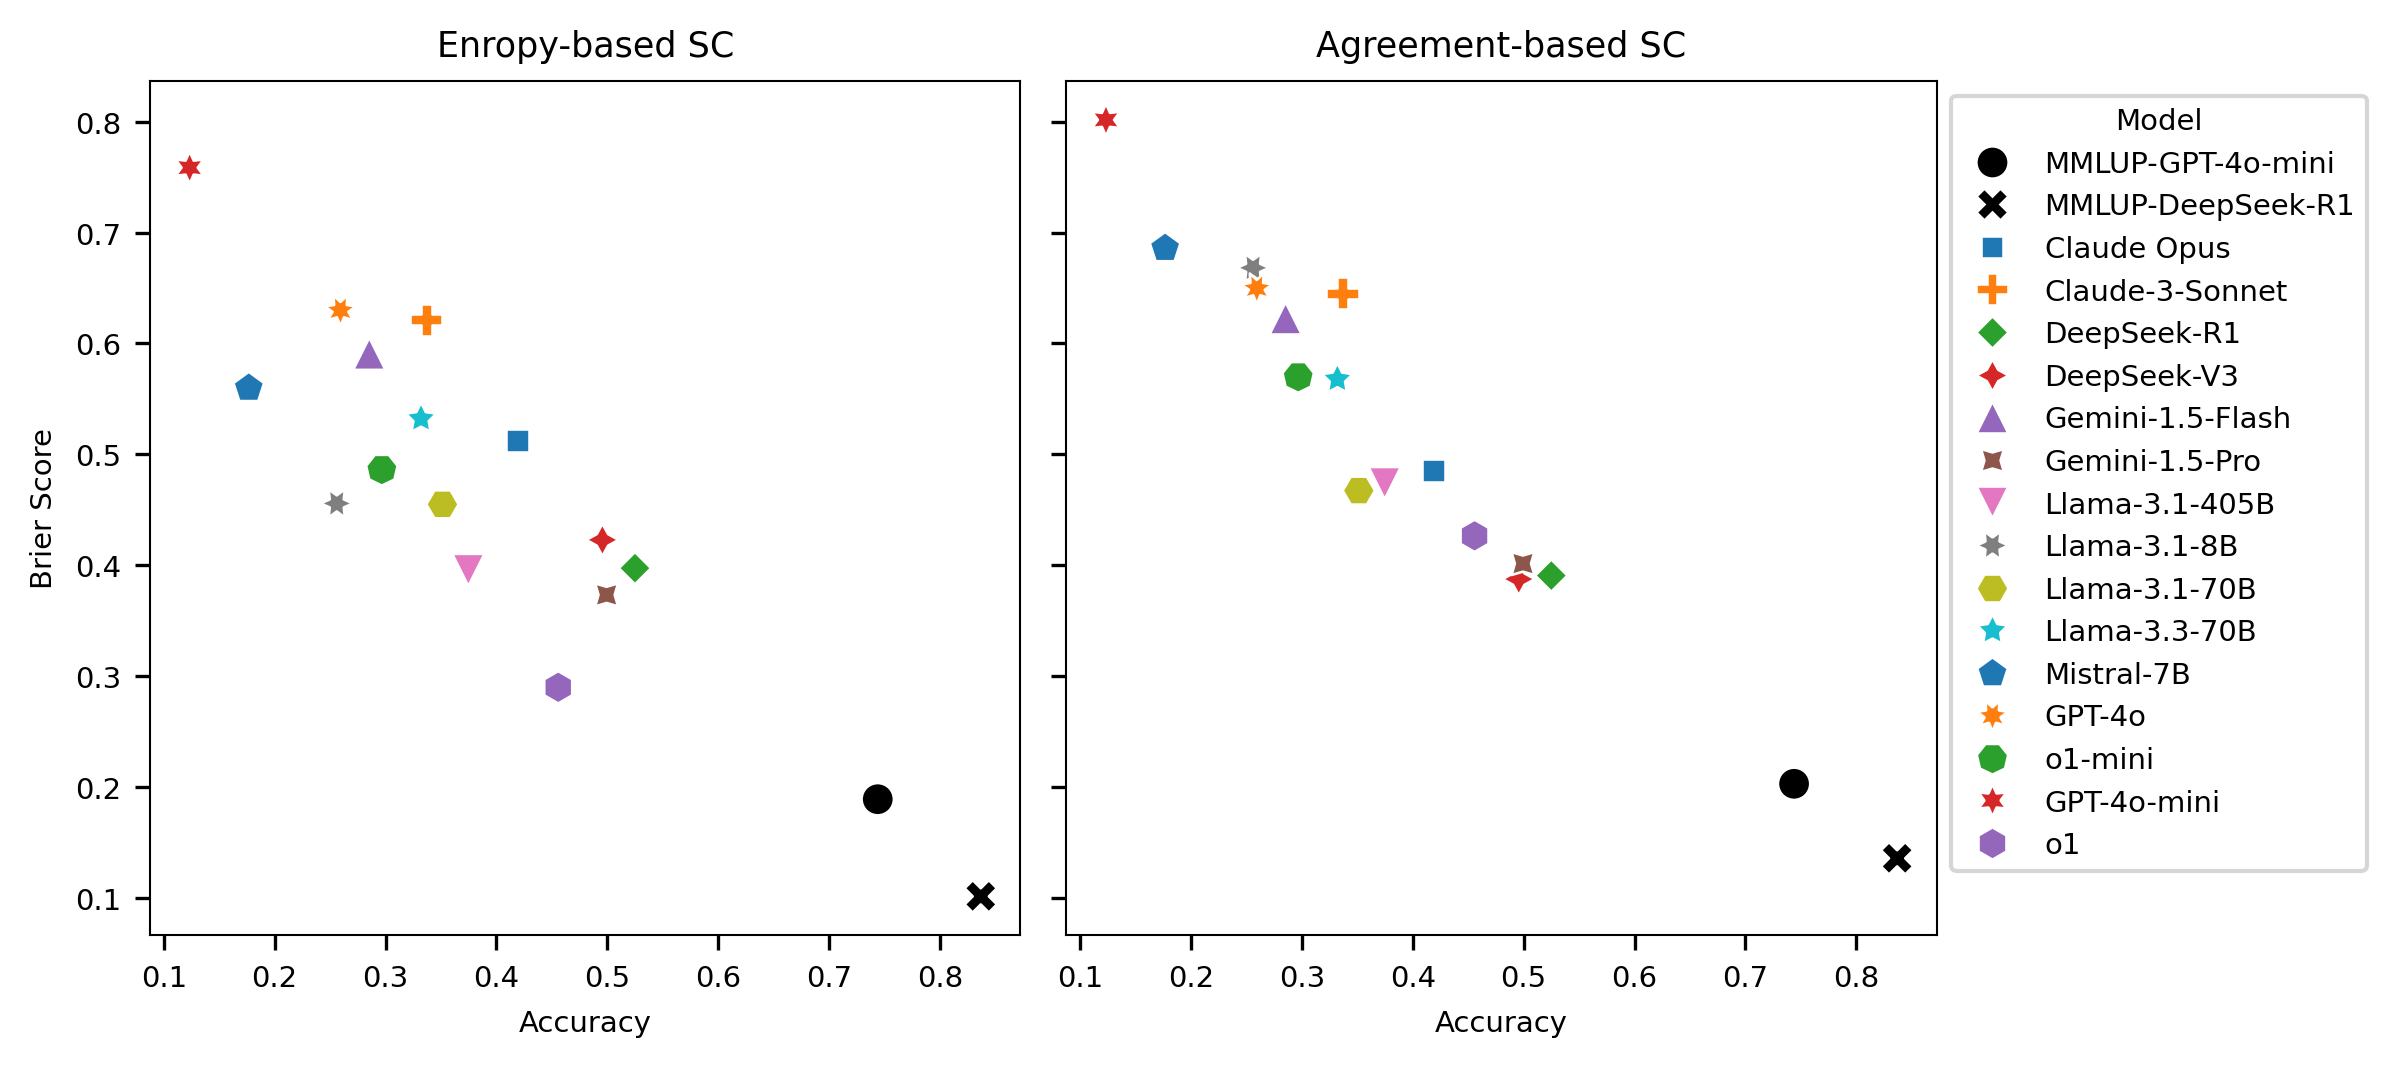

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

sns.scatterplot(data=df_bs_ent, x="Accuracy", y="Brier Score", s=60, palette=color_map,
                hue="Model", style="Model", ax=axs[0], legend=False)
axs[0].set_aspect('equal', adjustable='box')  # Force square aspect
axs[0].set_title('Enropy-based SC')

sns.scatterplot(data=df_bs, x="Accuracy", y="Brier Score", s=60, palette=color_map,
                hue="Model", style="Model", ax=axs[1])
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
axs[1].set_aspect('equal', adjustable='box')  # Force square aspect
axs[1].set_title('Agreement-based SC')

plt.tight_layout()
plt.show()


# Prepare Figure 1

In [30]:
# Fix model names
df = df_bs_ent.copy()

df["Model"] = df["Model"].str.replace('medalpaca-13b', 'Medalpaca-13b', regex=False)
df["Model"] = df["Model"].str.replace('Meditron3-8B', 'Meditron3-8b', regex=False)
df["Model"] = df["Model"].str.replace('Claude-3-Sonnet', 'Claude 3 Sonnet', regex=False)
df["Model"] = df["Model"].str.replace('Claude-3-Opus', 'Claude 3 Opus', regex=False)
df["Model"] = df["Model"].str.replace('Claude Opus', 'Claude 3 Opus', regex=False)
df["Model"] = df["Model"].str.replace('Mistral 7b', 'Mistral 7B', regex=False)
df["Model"] = df["Model"].str.replace('Mistral-7B', 'Mistral 7B', regex=False)
# df["model"] = df["model"].str.replace('Llama-3.1-8B', 'Llama 3.1 8b', regex=False)
# df["model"] = df["model"].str.replace('Llama-3.1-70B', 'Llama 3.1 70b', regex=False)
# df["model"] = df["model"].str.replace('Llama3.1-405b-instruct-fp8', 'Llama 3.1 405b(fp8)', regex=False)
# df["model"] = df["model"].str.replace('gemini-1.5-flash-latest', 'Gemini 1.5 Flash', regex=False)
# df["model"] = df["model"].str.replace('gemini-1.5-pro-latest', 'Gemini 1.5 Pro', regex=False)
# df["model"] = df["model"].str.replace('gpt-4o-mini', 'GPT-4o-mini', regex=False)
# df["model"] = df["model"].str.replace('gpt-4o', 'GPT-4o', regex=False)
# df["model"] = df["model"].str.replace('o1-2024-12-17_200000', 'o1', regex=False)
# df["model"] = df["model"].str.replace('deepseek-reasoner', 'DeepSeek Reasoner', regex=False)
# df["model"] = df["model"].str.replace('deepseek-chat', 'DeepSeek Chat', regex=False)
df["Model"] = df["Model"].str.replace('Gemini-1.5', 'Gemini 1.5', regex=False)
df["Model"] = df["Model"].str.replace('Llama-3.1', 'Llama 3.1', regex=False)
# df["Model"] = df["Model"].str.replace('GPT-4o', 'GPT-4o', regex=False)
df["Model"] = df["Model"].str.replace('Chat', 'V3', regex=False)
df["Model"] = df["Model"].str.replace('Reasoner', 'R1', regex=False)

df

,Model (det),Brier Score,Family,Model,Accuracy,CI_l,CI_h
16,baseline-GPT-4o-mini,0.189060,Baseline,MMLUP-GPT-4o-mini,0.743832,0.739370,0.748556
15,baseline-DeepSeek-R1,0.101464,Baseline,MMLUP-DeepSeek-R1,0.836745,0.832808,0.843832
1,Claude-3-opus,0.512626,Claude,Claude 3 Opus,0.418667,0.405333,0.430667
5,Claude-3-sonnet,0.621469,Claude,Claude 3 Sonnet,0.336667,0.326384,0.339333
9,DeepSeek-R1,0.397402,DeepSeek,DeepSeek-R1,0.524913,0.515076,0.533700
0,DeepSeek-V3,0.422892,DeepSeek,DeepSeek-V3,0.495571,0.480152,0.514667
10,Gemini-1.5-flash,0.590773,Gemini,Gemini 1.5-Flash,0.285333,0.276667,0.293333
4,Gemini-1.5-pro,0.373305,Gemini,Gemini 1.5-Pro,0.499333,0.484667,0.512667
7,llama3.1-405b-instruct-fp8,0.395728,Llama,Llama 3.1-405B,0.374667,0.358000,0.387333
3,Llama-3.1-8B-Instruct,0.455783,Llama,Llama 3.1-8B,0.256000,0.248000,0.277689


In [33]:
# Sore models
model_order = [
    "Mistral 7B",
    "Llama 3.1-8B",
    "Llama 3.1-70B",
    "Llama 3.1-405B",
    "Llama-3.3-70B",
    "Claude 3 Sonnet",
    "Claude 3 Opus",
    "Gemini 1.5-Flash",
    "Gemini 1.5-Pro",
    "GPT-4o-mini",
    "GPT-4o",
    "o1-mini",
    "o1",
    "DeepSeek-V3",
    "DeepSeek-R1",
    "Human",
]

df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

df = df.sort_values('Model').reset_index(drop=True)

# Drop baseline rows
df = df.iloc[:-2]

In [34]:
df

,Model (det),Brier Score,Family,Model,Accuracy,CI_l,CI_h
0,Mistral-7B-Instruct-v0.3,0.559863,Mistral,Mistral 7B,0.176667,0.167333,0.184000
1,Llama-3.1-8B-Instruct,0.455783,Llama,Llama 3.1-8B,0.256000,0.248000,0.277689
2,Llama-3.1-70B-Instruct,0.454965,Llama,Llama 3.1-70B,0.351333,0.329559,0.371333
3,llama3.1-405b-instruct-fp8,0.395728,Llama,Llama 3.1-405B,0.374667,0.358000,0.387333
4,Llama-3.3-70B-Instruct,0.532225,Llama,Llama-3.3-70B,0.332000,0.320000,0.344000
5,Claude-3-sonnet,0.621469,Claude,Claude 3 Sonnet,0.336667,0.326384,0.339333
6,Claude-3-opus,0.512626,Claude,Claude 3 Opus,0.418667,0.405333,0.430667
7,Gemini-1.5-flash,0.590773,Gemini,Gemini 1.5-Flash,0.285333,0.276667,0.293333
8,Gemini-1.5-pro,0.373305,Gemini,Gemini 1.5-Pro,0.499333,0.484667,0.512667
9,GPT-4o-mini,0.758588,OpenAI,GPT-4o-mini,0.123333,0.112085,0.132667


In [35]:
human_scores = [.83, .61, .65, 0.47, 0.72]
human_avg = np.mean(human_scores) 

res = bootstrap(
    data=(human_scores,),         # (data,) -> single dataset
    statistic=np.mean,            # function to bootstrap
    confidence_level=0.95,        # 95% CI
    n_resamples=2000,             # number of bootstrap resamples
    method='BCa',                 # Bias-corrected and accelerated (BCa)
    random_state=42               # for reproducibility
)

ci = res.confidence_interval

df.loc[-1] = ['Human', 'NaN', 'NaN', 'Human', human_avg, ci[0], ci[1]] 


df['colors'] = ['#ff7f0e', 
                '#d62728',  '#d62728', '#d62728', '#d62728', # ,
                '#9467bd', '#9467bd',
                '#8c564b', '#8c564b', 
                '#f7b6d2', '#f7b6d2',
                 '#e377c2', '#e377c2', "#17becf", "#17becf",# ,
               '#7f7f7f'] 



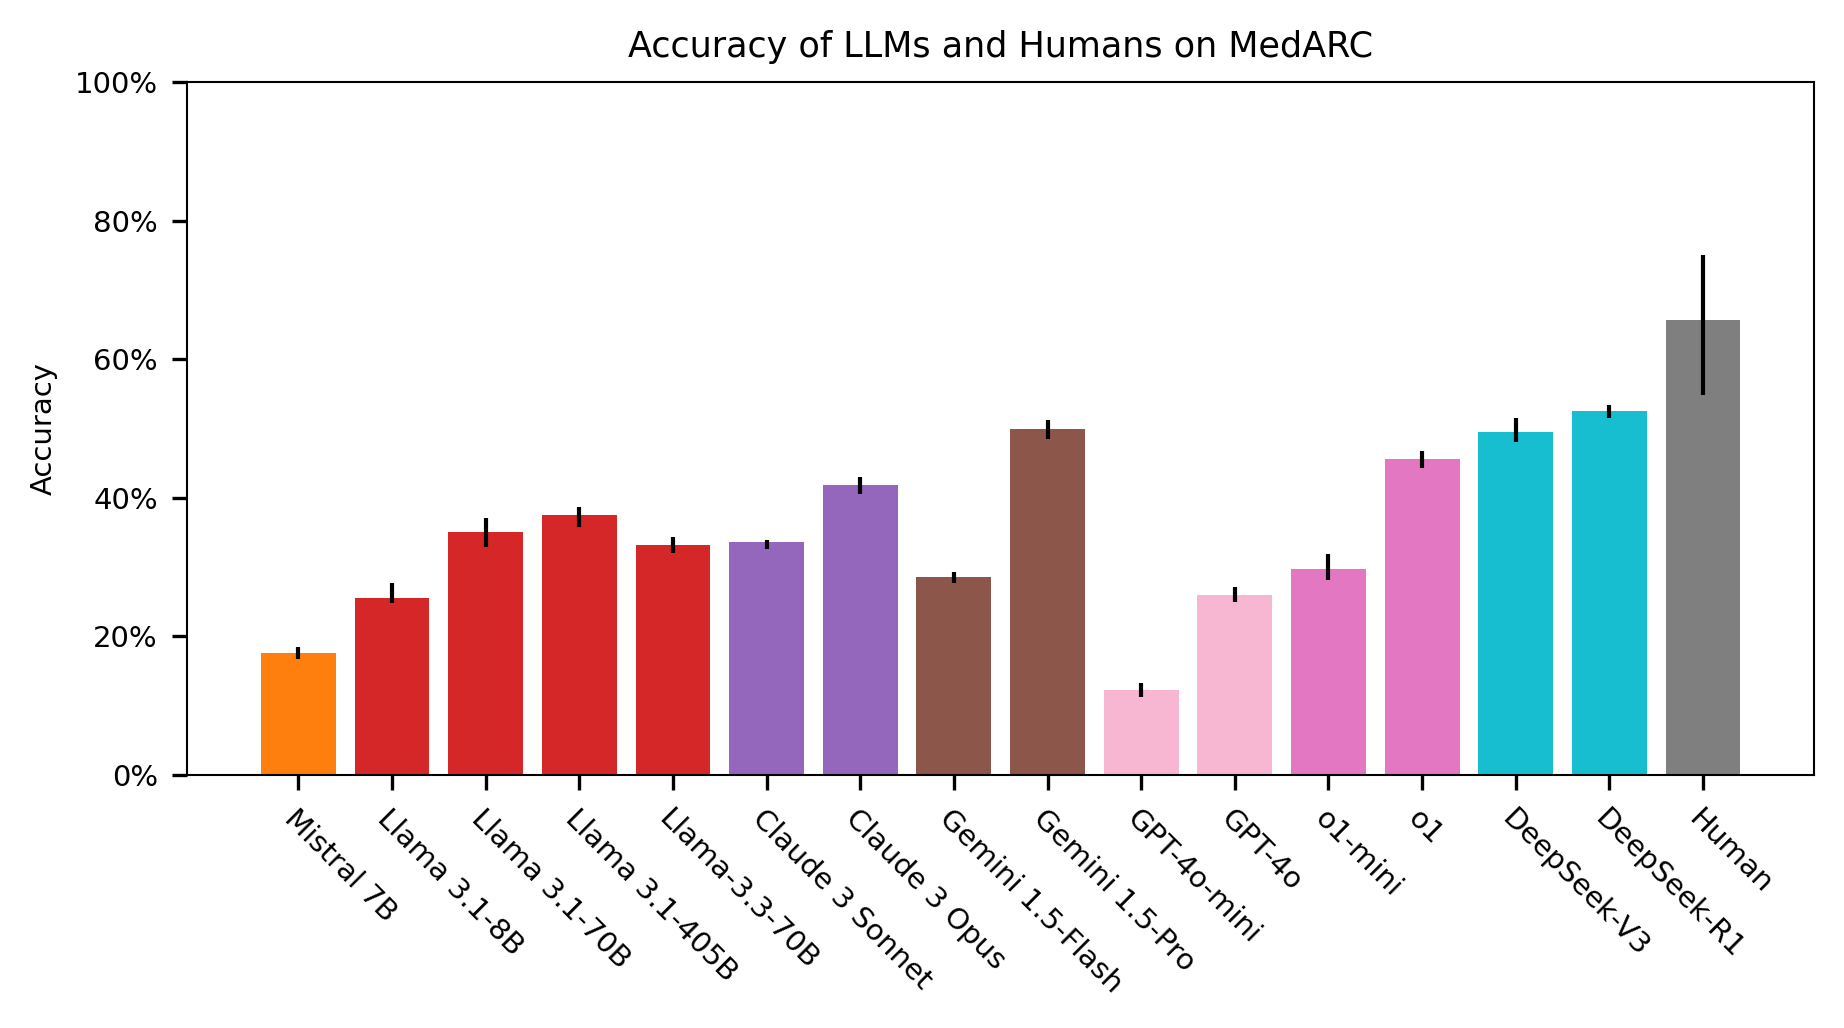

In [36]:
models = df['Model']
accuracies = df['Accuracy']

fig, ax = plt.subplots(figsize=(7,3))

ci_low     = df['CI_l']
ci_high    = df['CI_h']

# Compute lower and upper error ranges
y_err_lower = accuracies - ci_low
y_err_upper = ci_high - accuracies

# Group colors
ax.bar(models, accuracies, 
       color=df['colors'],
      yerr=[y_err_lower, y_err_upper],)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of LLMs and Humans on MedARC')

ax.set_ylim(0, 1)  
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))

plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor" ) 

plt.ylim(0,1)
plt.show()


# Calculate significance

In [37]:
def paired_bootstrap_diff(human_arr, model_arr, n_resamples=10_000, random_state=42):
    rng = np.random.default_rng(random_state)
    N = len(human_arr)
    diffs = []

    observed_diff = np.mean(model_arr) - np.mean(human_arr)

    for _ in range(n_resamples):
        idxs = rng.choice(N, size=N, replace=True)
        diff = np.mean(model_arr[idxs]) - np.mean(human_arr[idxs])
        diffs.append(diff)

    diffs = np.array(diffs)

    if observed_diff >= 0:
        fraction_opposite = np.mean(diffs <= 0)
    else:
        fraction_opposite = np.mean(diffs >= 0)

    p_value = 2.0 * fraction_opposite
    p_value = min(p_value, 1.0)

    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])

    return observed_diff, p_value, (ci_low, ci_high)

In [72]:
human_corrects = np.loadtxt('human_correct.txt', dtype=int)


In [73]:
# Average correctness across the 5 humans, per question
human_correct_avg = human_corrects.mean(axis=0)  # shape (100,)

main_path = 'eval_uq_results'
model_result_paths = glob.glob(os.path.join(main_path, '*/'))

for model_path in model_result_paths:
    if '3.3' in model_path:
        continue

    uq_file_pattern = os.path.join(model_path, 'run*/*_health_result.json')
    uq_file_paths = glob.glob(uq_file_pattern)

    final_df = pd.DataFrame()
    
    correct_answers = {}
    
    for n, file_path in enumerate(uq_file_paths):
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)
            
            pred_dict = {item["question_id"]: item["pred"] for item in content}
            pred_df = pd.DataFrame([pred_dict])
            pred_df.columns = [f"question_{col}" for col in pred_df.columns]

            # Accumulate predictions from different runs
            final_df = pd.concat([final_df, pred_df], ignore_index=True)

            if n == 0:
                # Record correct answers from first file read
                for item in content:
                    ans = item["answer"]
                    if ans is None:
                        # Convert numeric index to letter
                        mult_choice_answers = list(string.ascii_uppercase[:27])
                        ans_idx = item["answer_index"]
                        ans = mult_choice_answers[ans_idx]
                    correct_answers[item["question_id"]] = ans
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    print(file_path.split('/')[1])

    first_row = final_df.iloc[0]  

    model_correct = []
    for col in first_row.index:
        pred = first_row[col]  
        question_id = col.split('_')[1]  
        ground_truth = correct_answers.get(question_id)
        is_correct = 1 if (pred == ground_truth) else 0
        model_correct.append(is_correct)

    model_correct = np.array(model_correct)  # shape (100,)

    # Paired bootstrap: Model - Human 
    obs_diff, p_val, (ci_low, ci_high) = paired_bootstrap_diff(
        human_correct_avg,
        model_correct,
        n_resamples=5000,
        random_state=42
    )

    print("Paired Bootstrap vs. 5-human average:")
    print(f"  Observed difference (Model - Human) = {obs_diff:.3f}")
    print(f"  p-value = {p_val:.4f}  |  95% CI = [{ci_low:.3f}, {ci_high:.3f}]")


deepseek-chat
Paired Bootstrap vs. 5-human average:
  Observed difference (Model - Human) = -0.136
  p-value = 0.0068  |  95% CI = [-0.234, -0.036]
claude-3-opus-20240229
Paired Bootstrap vs. 5-human average:
  Observed difference (Model - Human) = -0.276
  p-value = 0.0000  |  95% CI = [-0.374, -0.172]
Llama-3.1-70B-Instruct
Paired Bootstrap vs. 5-human average:
  Observed difference (Model - Human) = -0.266
  p-value = 0.0000  |  95% CI = [-0.360, -0.172]
Llama-3.1-8B-Instruct
Paired Bootstrap vs. 5-human average:
  Observed difference (Model - Human) = -0.416
  p-value = 0.0000  |  95% CI = [-0.508, -0.320]
gemini-1.5-pro-latest
Paired Bootstrap vs. 5-human average:
  Observed difference (Model - Human) = -0.126
  p-value = 0.0104  |  95% CI = [-0.222, -0.026]
claude-3-sonnet-20240229
Paired Bootstrap vs. 5-human average:
  Observed difference (Model - Human) = -0.316
  p-value = 0.0000  |  95% CI = [-0.414, -0.216]
gpt-4o
Paired Bootstrap vs. 5-human average:
  Observed difference 

# multiple comparisons correction

In [76]:

from statsmodels.stats.multitest import multipletests


def paired_bootstrap_diff(human_arr, model_arr, n_resamples=10_000, random_state=42):
    """
    Perform a paired bootstrap of the difference in mean correctness: model - human.
    Returns:
      observed_diff: difference on the full data
      p_value:       fraction of bootstrap samples that cross 0 in a "sign-based" way
      ci_95:         (low, high) 95% confidence interval from empirical percentiles
    """
    rng = np.random.default_rng(random_state)
    N = len(human_arr)
    diffs = []

    observed_diff = np.mean(model_arr) - np.mean(human_arr)

    for _ in range(n_resamples):
        idxs = rng.choice(N, size=N, replace=True)
        diff = np.mean(model_arr[idxs]) - np.mean(human_arr[idxs])
        diffs.append(diff)

    diffs = np.array(diffs)

    # Sign-based two-sided p-value:
    if observed_diff >= 0:
        fraction_opposite = np.mean(diffs <= 0)
    else:
        fraction_opposite = np.mean(diffs >= 0)

    p_value = 2.0 * fraction_opposite
    p_value = min(p_value, 1.0)

    # 95% CI from percentiles
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])

    return observed_diff, p_value, (ci_low, ci_high)

human_correct_avg = human_corrects.mean(axis=0)  # shape (100,)

main_path = 'eval_uq_results'
model_result_paths = glob.glob(os.path.join(main_path, '*/'))

results = []  
for model_path in model_result_paths:
    uq_file_pattern = os.path.join(model_path, 'run*/*_health_result.json')
    uq_file_paths = glob.glob(uq_file_pattern)

    if not uq_file_paths:
        continue

    final_df = pd.DataFrame()
    correct_answers = {}

    for n, file_path in enumerate(uq_file_paths):
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)
            pred_dict = {item["question_id"]: item["pred"] for item in content}
            pred_df = pd.DataFrame([pred_dict])
            pred_df.columns = [f"question_{col}" for col in pred_df.columns]
            final_df = pd.concat([final_df, pred_df], ignore_index=True)

            if n == 0:
                for item in content:
                    ans = item["answer"]
                    if ans is None:
                        mult_choice_answers = list(string.ascii_uppercase[:27])
                        ans_idx = item["answer_index"]
                        ans = mult_choice_answers[ans_idx]
                    correct_answers[item["question_id"]] = ans
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    model_name = os.path.basename(model_path.strip('/'))

    if final_df.empty:
        print(f"No data found for model path: {model_path}")
        continue

    first_row = final_df.iloc[0]  
    
    model_correct = []
    for col in first_row.index:
        pred = first_row[col]  
        question_id = col.split('_')[1]  # "ID001"
        ground_truth = correct_answers.get(question_id)
        is_correct = 1 if (pred == ground_truth) else 0
        model_correct.append(is_correct)

    model_correct = np.array(model_correct)

    # Paired bootstrap: Model - Human
    obs_diff, p_val, (ci_low, ci_high) = paired_bootstrap_diff(
        human_correct_avg, model_correct, n_resamples=5000, random_state=42
    )

    results.append({
        "model": model_name,
        "observed_diff": obs_diff,
        "p_val": p_val,
        "ci_low": ci_low,
        "ci_high": ci_high
    })


# Multiple Comparisons Correction
if results:
    raw_pvals = [r["p_val"] for r in results]

    reject, pvals_corrected, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')

    print("\n=== RESULTS ===")
    for (r, padj, rej) in zip(results, pvals_corrected, reject):
        print(f"Model: {r['model']}")
        print(f"  Observed diff (Model - Human) = {r['observed_diff']:.3f}")
        print(f"  95% CI = [{r['ci_low']:.3f}, {r['ci_high']:.3f}]")
        print(f"  Uncorrected p = {r['p_val']:.6f}")
        print(f"  Corrected p   = {padj:.6f}")
        print(f"  Reject H0?    = {rej}")
        print("")

else:
    print("No results to display.")



=== RESULTS ===
Model: deepseek-chat
  Observed diff (Model - Human) = -0.136
  95% CI = [-0.234, -0.036]
  Uncorrected p = 0.006800
  Corrected p   = 0.015600
  Reject H0?    = True

Model: claude-3-opus-20240229
  Observed diff (Model - Human) = -0.276
  95% CI = [-0.374, -0.172]
  Uncorrected p = 0.000000
  Corrected p   = 0.000000
  Reject H0?    = True

Model: Llama-3.1-70B-Instruct
  Observed diff (Model - Human) = -0.266
  95% CI = [-0.360, -0.172]
  Uncorrected p = 0.000000
  Corrected p   = 0.000000
  Reject H0?    = True

Model: Llama-3.1-8B-Instruct
  Observed diff (Model - Human) = -0.416
  95% CI = [-0.508, -0.320]
  Uncorrected p = 0.000000
  Corrected p   = 0.000000
  Reject H0?    = True

Model: gemini-1.5-pro-latest
  Observed diff (Model - Human) = -0.126
  95% CI = [-0.222, -0.026]
  Uncorrected p = 0.010400
  Corrected p   = 0.015600
  Reject H0?    = True

Model: claude-3-sonnet-20240229
  Observed diff (Model - Human) = -0.316
  95% CI = [-0.414, -0.216]
  Uncorr